In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import chi2
import seaborn as sns
from pprint import pprint
import time
from timeit import default_timer as timer

import string
import re
from stop_words import get_stop_words
import nltk, html

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, train_test_split, ParameterGrid, KFold, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

__1. Data Creation__

In [2]:
df = pd.read_csv(r'Desktop\development.csv')

X = df['text']
y = df['sentiment']

__2. Data Exploration__

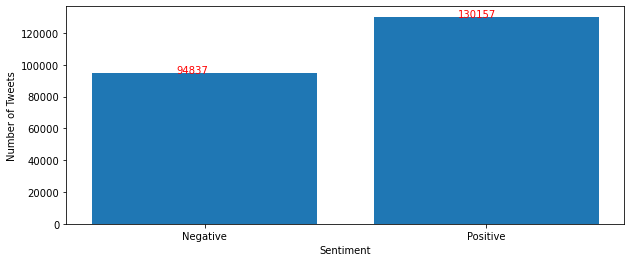

In [3]:
count = Counter(y)
labels = ['Positive', 'Negative']
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(count.keys(), count.values(), tick_label = labels)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
#fig.suptitle('Number of tweets in Category')
for index, data in enumerate(sorted(count.values())):
    plt.text(x = index - .1 , y = data + 2 , s=f"{data}" , fontdict=dict(fontsize=10), color='red')
plt.show()

__3. Preprocessing and Feature Engineering__

__3-1. Text Cleaning__

In [4]:
stop_words = get_stop_words('english')
#instantiation for stemming
lemma = nltk.wordnet.WordNetLemmatizer()

def tokenize(doc):
    """Compute the tokens for each document.

    Input: a list of strings. Each item is a document to tokenize.
    Output: a list of lists. Each item is a list containing the tokens of the relative document.
    """
    tokens = []
    for tweet in doc:
        
        tweet = html.unescape(tweet) # Escaping out HTML characters
        tweet = tweet.replace('"', '') # quoting
        tweet = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", tweet) # removing email
        tweet = re.sub("(.)\\1{2,}", "\\1", tweet) # removing repeatetive letters in a word
        tweet = " ".join(tweet.split()) 
        tweet=tweet.lower() # convert to lower case
        split_doc = [lemma.lemmatize(token) for token in tweet.split(" ") if ((token not in stop_words) and (token not in string.punctuation))]
        target = ' '.join(split_doc) # getting sentence from a list
        
        tokens.append(target) # adding to final list
    return tokens

X_token = tokenize(X)

__3-2. Train-Test Split__

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_token, y, test_size=.2, stratify=y, shuffle=True, random_state=42)

__3-3. Text Representation/Feature Creation__

In [6]:
tfidf = TfidfVectorizer(max_features=8000, lowercase=False, sublinear_tf=True)
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test)
labels_test = y_test
print(features_test.shape)

(179995, 8000)
(44999, 8000)


__4. SVC as Final Model with Tunned Hyperparameters__

__4-1. SVM and Fixed Hyperparameters for Cross Validation__

In [7]:
# =============Support Vector=============
svc = svm.SVC(random_state = 8)

# =============Cross-Validation for Hyperparameter Tuning=============
# C
C = [1]

#gamma
gamma = [.001]

# kernel for textual classification
kernel = ['linear']

#probability
probability = [True]

# Create the random grid
param_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'probability': probability
             }

__4-2. Performing Grid Search Cross-Validation__

In [8]:
# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train[:15000], labels_train[:15000])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid={'C': [1], 'gamma': [0.001], 'kernel': ['linear'],
                         'probability': [True]},
             scoring='f1_macro', verbose=1)

In [9]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1, 'gamma': 0.001, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.7130597634898571


__4-3. Fitting and Prediction by Best Model__

In [10]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=1, gamma=0.001, kernel='linear', probability=True, random_state=8)

In [11]:
# =============Model Fitting and Performance=============
best_svc.fit(features_train, labels_train)

start = timer()
svc_pred = best_svc.predict(features_test)
end = timer()
print('time is: ',end-start)

time is:  292.50082140000086


__4-4. Test Accuracy__

In [13]:
print("The test accuracy is: ")
print(f1_score(labels_test, svc_pred, average='macro'))

The test accuracy is: 
0.7587292410659935


__4-5. Classification Report__

In [14]:
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.76      0.66      0.71     18967
           1       0.78      0.85      0.81     26032

    accuracy                           0.77     44999
   macro avg       0.77      0.75      0.76     44999
weighted avg       0.77      0.77      0.77     44999



__5. Importing Evaluation Set__

In [15]:
evaluation_data = pd.read_csv(r'Desktop\evaluation.csv')
evaluation_data.head()

,ids,date,flag,user,text
0,1999928613,Mon Jun 01 21:04:54 PDT 2009,NO_QUERY,urbanperspectiv,@engteacher I'm pretty much the same ...in eit...
1,1827919331,Sun May 17 11:43:09 PDT 2009,NO_QUERY,therealsecret,@JaxLicurse same here have a gr8 week ahead
2,1563640134,Sun Apr 19 23:37:52 PDT 2009,NO_QUERY,bitchville,@blacksweater that's just nightmares all over
3,2189786396,Tue Jun 16 00:54:27 PDT 2009,NO_QUERY,epi_longo,@dlead @jishanvn cháº¯c pháº£i Äi thi Äáº¡i ...
4,1974034022,Sat May 30 12:18:33 PDT 2009,NO_QUERY,Curiosafmmb,@CA_Sweetie awe. ok sweetie. ttyl. *hugs*


__5-1. Preparing Texts__

In [38]:
evaluation_text = evaluation_data['text']
evaluation_text

0        @engteacher I'm pretty much the same ...in eit...
1            @JaxLicurse same here  have a gr8 week ahead 
2           @blacksweater  that's just nightmares all over
3        @dlead @jishanvn cháº¯c pháº£i Äi thi Äáº¡i ...
4              @CA_Sweetie awe. ok sweetie. ttyl.   *hugs*
                               ...                        
74994    @NIYANA man down,code 10...I'm going 2 try &am...
74995    @senhordaguerra Thank you for following me: I ...
74996    Why isn't Friday's Hollyoaks available for dow...
74997    @hollywilli she WAS !!! she was a MADAM they q...
74998    Plans for today = shower, shopping, rent some ...
Name: text, Length: 74999, dtype: object

In [42]:
evaluation_token = tokenize(evaluation_text)
evaluation_token

['pretty much .in either world',
 'gr8 week ahead',
 'just nightmare',
 'cháº¯c pháº£i ä\x91i thi ä\x91áº¡i há»?c tháº\xadt quã¡',
 '_sweetie awe. ok sweetie. ttyl. *hugs*',
 'just saw ad grey anatomy..never watched naww poor izzie',
 'cant wait see complete new moon trailer mtv movie awards!! wo!! love vampires..and werewolf',
 'love music calm',
 'shoot finna find cutty buddy.',
 "y'all! rockin ur stuff okc da katt! tune w.katt.com anytime!",
 'bought blog, kindle. really looking forward reading vacation.',
 'ah yes, asked yesterday! silly good run brilliant day',
 'play heaven remix ?! didnt mean rofl',
 'thanks trying now..',
 'wanna go home. miss skypies',
 'aw..now thats just plain adorable',
 'singing little teapot. day now.',
 'thanks!',
 'beg to?',
 'good you!!',
 'u add u',
 'ooh oh u go there?',
 '15.02 back today',
 'hey! text u, stupid bitch took phone 2day',
 "social security cost living increase 2010 2011!! oh sure.wait *i'm* receiving s stop increases!!",
 'boo mean, li

In [43]:
evaluation_test = tfidf.transform(evaluation_token)
print(evaluation_test.shape)

(74999, 8000)


__5-2. Prediction__

In [44]:
svc_evaluation_pred = best_svc.predict(evaluation_test)

In [45]:
svc_evaluation_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

__5-3. Creating CSV File__

In [46]:
result = pd.Series(svc_evaluation_pred)
result

0        1
1        1
2        0
3        1
4        1
        ..
74994    1
74995    1
74996    0
74997    0
74998    1
Length: 74999, dtype: int64

In [47]:
df_result = pd.DataFrame({'Id': result.index, 'Predicted': result.values})
df_result

,Id,Predicted
0,0,1
1,1,1
2,2,0
3,3,1
4,4,1
...,...,...
74994,74994,1
74995,74995,1
74996,74996,0
74997,74997,0


In [48]:
df_result.to_csv('submission.csv', sep=',', index=False)